# Result Notebook

In [1]:
import json

import numpy as np
import pandas as pd

from IPython.display import display
from pathlib import Path
from omegaconf import OmegaConf

result_path = Path('../results/')

In [2]:
# Define loading functions
def get_experiments(result_path, glob_pattern):
    experiments = []
    for exp_path in result_path.glob(glob_pattern):

        exp_json = exp_path / 'results_final.json'
        exp_cfg = exp_path / '.hydra' / 'config.yaml'

        try:
            with open(exp_json, 'r') as f:
                data = json.load(f)
                cfg = {}  # OmegaConf.load(exp_cfg)

            result_dict_final_epoch = data['test_history'][-1]
            experiments.append({'results': result_dict_final_epoch, 'cfg': cfg})
        except:
            print(f'{exp_path} has missing results.')
    return experiments

def get_metric_dict(experiments, ignore_metrics=[], return_std=False):
    metric_names = list(experiments[0]['results'].keys())
    d = {}
    for metric_name in metric_names:
        if metric_name in ignore_metrics:
            continue
        value = np.mean([exp['results'][metric_name] for exp in experiments])
        d[metric_name] = value
        if return_std:
            std = np.std([exp['results'][metric_name] for exp in experiments])
            d[metric_name+'_std'] = std
    return d
# experiments = get_experiments(result_path / 'CIFAR10__resnet18', glob_pattern='seed*')
# print(f'Found {len(experiments)} experiments')
# get_metric_dict(experiments)

## Results - ResNet18

In [4]:
ignore_metrics = [
    'test_SVHN_conf_auroc',
    'test_SVHN_conf_aupr',
    'test_SVHN_dempster_aupr',
    'test_SVHN_dempster_auroc',
    'test_prec',
    'test_loss',
    'test_SVHN_entropy_aupr',
]
exp_names = {
    'deterministic': 'CIFAR10__resnet18',
    "dropout": "CIFAR10__resnet18_mcdropout",
    "sngp": "CIFAR10__resnet18_sngp",
}

data = []
for key, name in exp_names.items():
    experiments = get_experiments(result_path / name, glob_pattern='seed*')
    metric_dict = get_metric_dict(experiments, ignore_metrics=ignore_metrics, return_std=False)
    data.append(metric_dict)

df = pd.DataFrame(data, index=exp_names.keys())
display(df)
# print(df.to_markdown())

,test_acc1,test_nll,test_tce,test_mce,test_SVHN_entropy_auroc
deterministic,95.245998,0.195328,0.046620,0.021937,0.948836
dropout,94.523997,0.163241,0.012984,0.013530,0.937801
sngp,95.162000,0.167379,0.025087,0.017029,0.956285


## Results - Wide-ResNet-28-10

In [3]:
ignore_metrics = [
    'test_SVHN_conf_auroc',
    'test_SVHN_conf_aupr',
    'test_SVHN_dempster_aupr',
    'test_SVHN_dempster_auroc',
    'test_prec',
    'test_loss',
    'test_SVHN_entropy_aupr',
]
exp_names = {
    'deterministic': 'CIFAR10__wideresnet2810',
    "dropout": "CIFAR10__wideresnet2810_mcdropout",
    "sngp": "CIFAR10__wideresnet2810_sngp",
}

data = []
for key, name in exp_names.items():
    experiments = get_experiments(result_path / name, glob_pattern='seed*')
    metric_dict = get_metric_dict(experiments, ignore_metrics=ignore_metrics, return_std=False)
    data.append(metric_dict)

df = pd.DataFrame(data, index=exp_names.keys())
display(df)
# print(df.to_markdown())

,test_acc1,test_nll,test_tce,test_mce,test_SVHN_entropy_auroc
deterministic,95.823997,0.169768,0.039066,0.022526,0.953189
dropout,96.327998,0.129223,0.014845,0.020601,0.957078
sngp,96.153999,0.337299,0.175229,0.067576,0.951147


## Load and Eval model

In [57]:
import tqdm
import torch
import pylab as plt

import sys
sys.path.insert(0, '../')

from models import build_model
from datasets import build_cifar10
from metrics import calibration

checkpoint = torch.load('../results/CIFAR10__wideresnet2810_sngp/seed1/checkpoint.pth')
model_dict = build_model(checkpoint['args'], n_classes=10, train_ds=None)
model = model_dict['model']
model(torch.randn(1, 3, 32, 32))
model.load_state_dict(checkpoint['model'])

test_ds = build_cifar10('test', '/tmp/')
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, sampler=None)# range(1000))

# Eval
model.to('cuda')
model.eval()
model.output_layer.mean_field_factor = np.pi/8
logits, targets = [], []
for inp, tar in tqdm.auto.tqdm(test_loader):
    with torch.no_grad():
        logits.append(model(inp.to('cuda'), mean_field=True).cpu())
        targets.append(tar)
logits = torch.cat(logits)
targets = torch.cat(targets)

Files already downloaded and verified


100%|██████████| 157/157 [00:16<00:00,  9.68it/s]


TCE: 0.01605556719005108 	 NLL: 0.1392102837562561


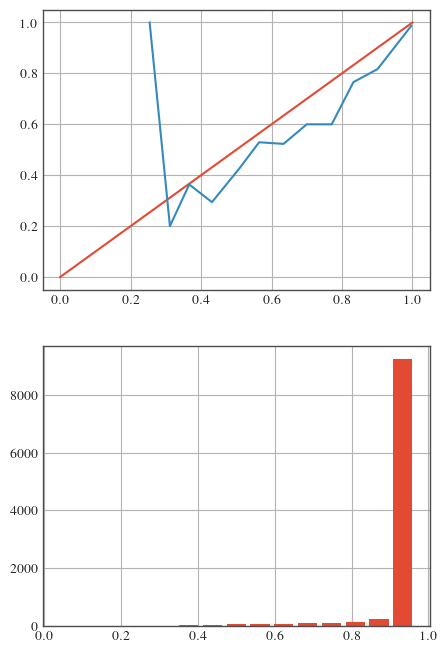

In [60]:
tce_criterion = calibration.TopLabelCalibrationError()
nll_criterion = torch.nn.CrossEntropyLoss()

tce = tce_criterion(logits.softmax(-1), targets)
nll = nll_criterion(logits, targets)

tcp_dict = tce_criterion.results
plt.figure(figsize=(5, 8))
plt.subplot(211)
plt.plot([0, 1], [0, 1])
plt.plot(tcp_dict['confs'], tcp_dict['accs'])
plt.subplot(212)
plt.bar(np.linspace(1/15, 1-1/15, 15), tcp_dict['n_samples'], width=.05)
print(f'TCE: {tce} \t NLL: {nll}')